<a href="https://colab.research.google.com/github/brianhuang66677/HLS-CNN/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# 檢查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用的設備：", device)

使用的設備： cuda


In [ ]:
# 沒有任何資料增強的 train transform
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071,0.4867,0.4408],
                         std=[0.2675,0.2565,0.2761]),
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071,0.4867,0.4408],
                         std=[0.2675,0.2565,0.2761]),
])

In [ ]:
# 下載並載入 CIFAR-100 資料集（若已下載則直接使用）
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

# DataLoader 設定
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:03<00:00, 48.5MB/s]


In [ ]:
# 定義 AlexNet 模型
model = models.alexnet(pretrained=False)

# 修改最後一層輸出，將 1000 類調整為 100 類
model.classifier[6] = nn.Linear(4096, 100)
model = model.to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# 訓練參數
num_epochs = 50
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 訓練與驗證迴圈
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    # 訓練階段
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print("Epoch [{}/{}] Step [{}/{}] Loss: {:.4f}".format(
                epoch+1, num_epochs, batch_idx, len(train_loader), loss.item()))

    train_acc = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    print("Epoch {} Training Loss: {:.4f}, Accuracy: {:.2f}%".format(epoch+1, avg_loss, train_acc))

    # 驗證階段
    model.eval()
    test_loss = 0.0
    total_test = 0
    correct_test = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_acc = 100. * correct_test / total_test
    avg_test_loss = test_loss / len(test_loader)
    print("Epoch {} Test Loss: {:.4f}, Test Accuracy: {:.2f}%\n".format(epoch+1, avg_test_loss, test_acc))

    # 儲存該 epoch 的數據
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50] Step [0/782] Loss: 4.6053
Epoch [1/50] Step [100/782] Loss: 4.6054
Epoch [1/50] Step [200/782] Loss: 4.6038
Epoch [1/50] Step [300/782] Loss: 4.6034
Epoch [1/50] Step [400/782] Loss: 4.4799
Epoch [1/50] Step [500/782] Loss: 4.4565
Epoch [1/50] Step [600/782] Loss: 4.1190
Epoch [1/50] Step [700/782] Loss: 4.1943
Epoch 1 Training Loss: 4.4488, Accuracy: 2.57%
Epoch 1 Test Loss: 4.1553, Test Accuracy: 5.53%

Epoch [2/50] Step [0/782] Loss: 4.4933
Epoch [2/50] Step [100/782] Loss: 4.0651
Epoch [2/50] Step [200/782] Loss: 4.2780
Epoch [2/50] Step [300/782] Loss: 3.9452
Epoch [2/50] Step [400/782] Loss: 3.6050
Epoch [2/50] Step [500/782] Loss: 3.6724
Epoch [2/50] Step [600/782] Loss: 3.6373
Epoch [2/50] Step [700/782] Loss: 3.4258
Epoch 2 Training Loss: 3.8170, Accuracy: 10.75%
Epoch 2 Test Loss: 3.5837, Test Accuracy: 14.92%

Epoch [3/50] Step [0/782] Loss: 3.6659
Epoch [3/50] Step [100/782] Loss: 3.3875
Epoch [3/50] Step [200/782] Loss: 3.4026
Epoch [3/50] Step [300/782] Loss:

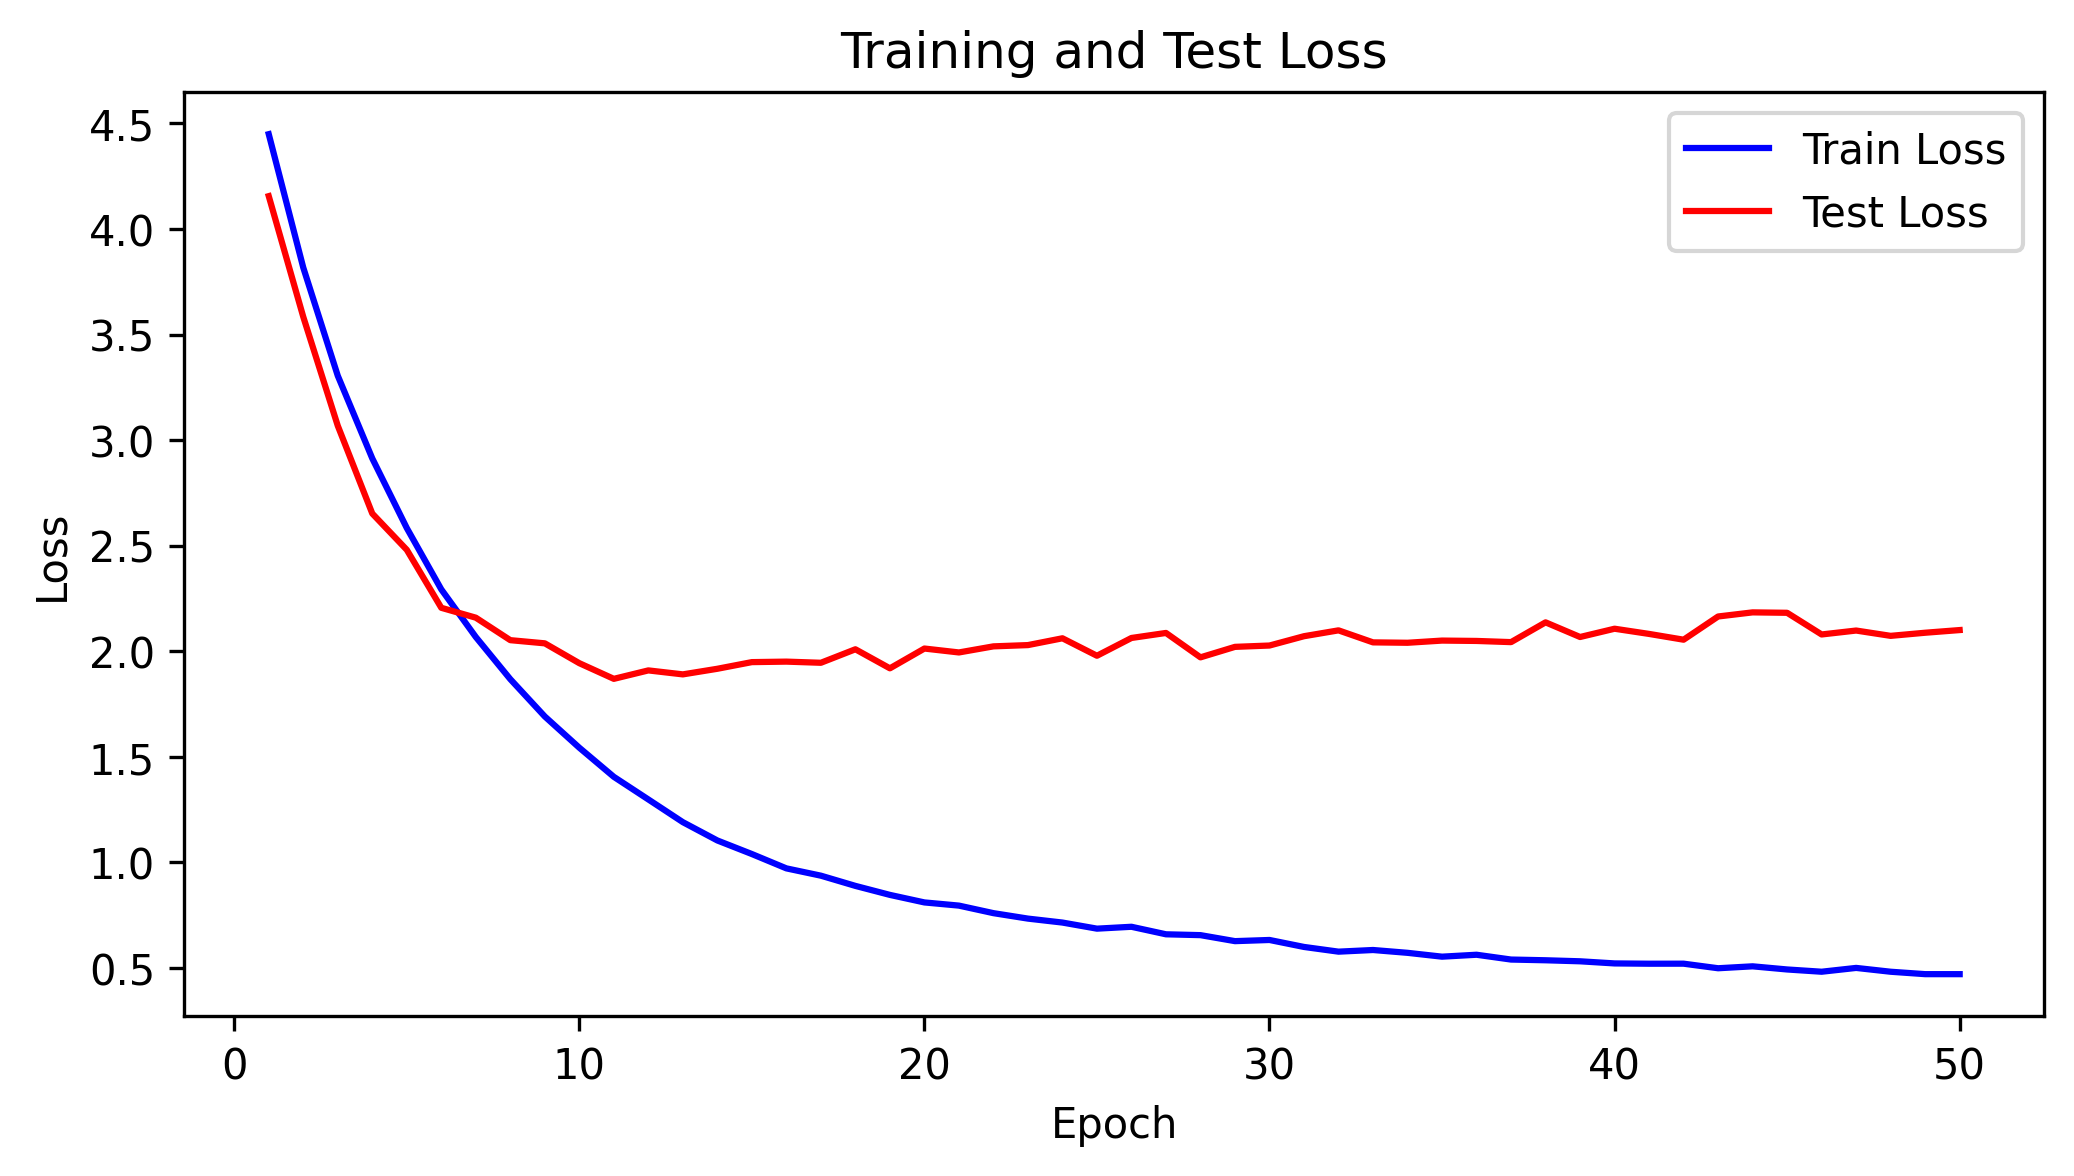

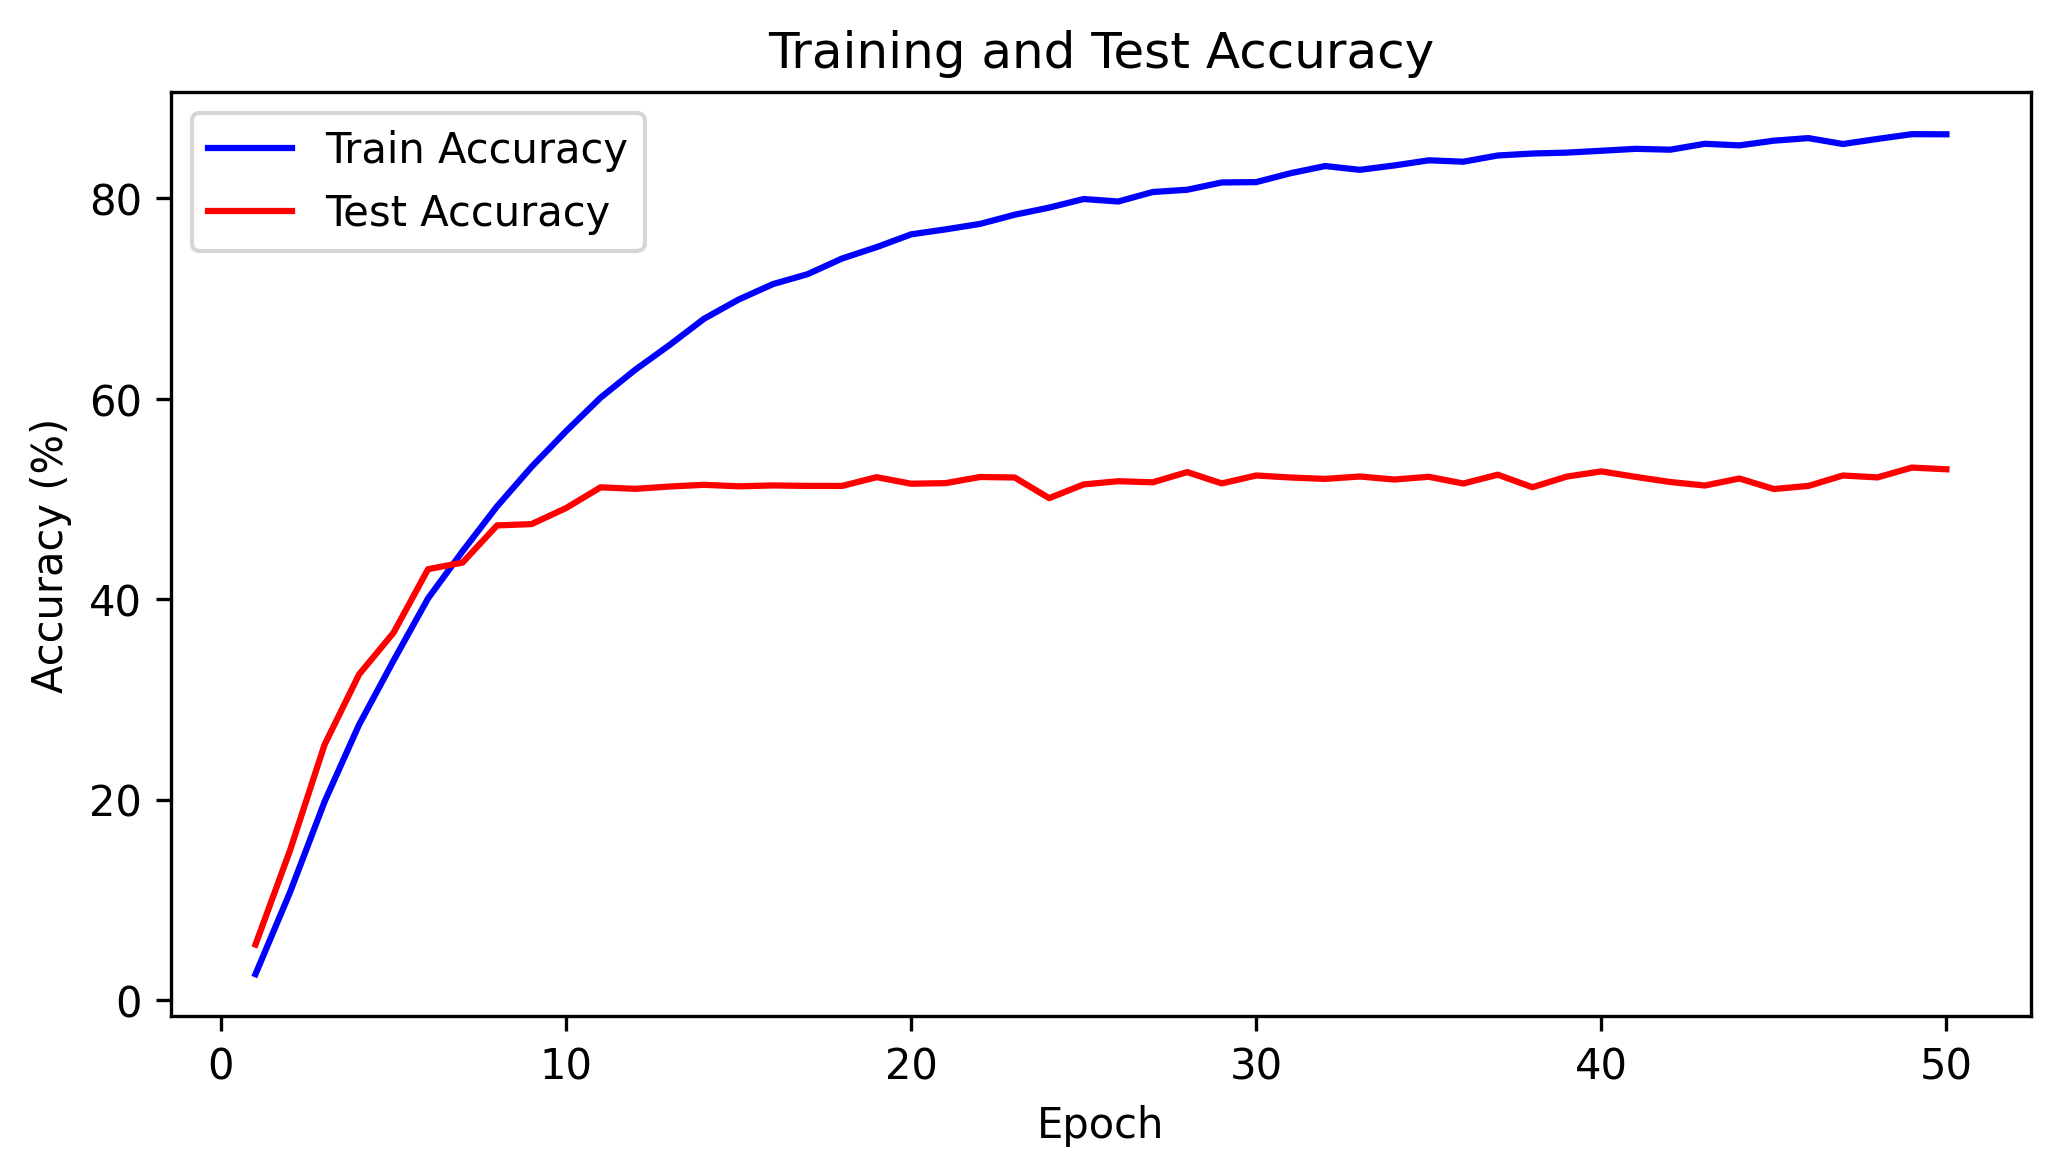

In [ ]:
# 畫出訓練與測試的 loss 與 accuracy 曲線圖
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8,4), dpi=300)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, test_losses, 'r-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,4), dpi=300)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()